TEXT

Imports

In [35]:
from random import randint
from copy import deepcopy
import numpy as np
import random
import matplotlib.pyplot as plt

Gridworld Class

In [36]:
# Assumes a 10x5 dimension gridworld

class gridWorld:
    def __init__(self):
        self.init_door=[9,1]
        self.agent=None
        self.door=None

        # added
        self.X_DIM = 10
        self.Y_DIM = 5

    def reset(self):
        self.door=self.init_door
        position=[-1,-1]
        while not self.isValid(position):
            position[0]=randint(0,9)
            position[1]=randint(0,4)
        self.agent=position
        return deepcopy(self.agent)
    
    # Select next action
    def select_action_idx(self, ep, state, Q):
        action_idx = None
        if random.random() < ep:
            action_idx = random.randint(0,3)
        else:
            action_idx = np.argmax(Q[state[0]][state[1]])
        return action_idx #["up","down","left","right"][action_idx]

    def take_action(self,action,position):
        x,y=position
        action = ["up","down","left","right"][action]
        if action=="up":
            x-=1
        if action=="down":
            x+=1
        if action=="left":
            y-=1
        if action=="right":
            y+=1
        if self.isValid([x,y]):
            return [x,y]
        return position

    def step(self,action,rng_door=False):
        self.agent=self.take_action(action,self.agent)
        if rng_door:
            #rng_action=["up","down","left","right"][randint(0,3)] #
            rng_action=randint(0,3)
            self.door=self.take_action(rng_action,self.door)
        if self.agent[0]==self.door[0] and self.agent[1]==self.door[1]:
            reward=20
        else:
            reward=-1
        return deepcopy(self.agent),reward

    def isValid(self,position):
        x,y=position
        if x<0 or x>9:      #out of x bounds
            return False
        if y<0 or y>4:      #out of y bounds
            return False
        if x==7 and y<3:    #if obstacle
            return False
        return True
    
    def display_world(self):
        for x in range(self.X_DIM):
            row = []
            for y in range(self.Y_DIM):
                coord = [x,y]
                if self.agent == coord:
                    row.append('A')
                elif x == 7 and y < 3:
                    row.append('X')
                elif self.door == coord:
                    row.append('D')
                else:
                    row.append('_')
            print(row)

Set up training parameters

In [37]:
# =========== TRAINING ===========

# TRAINING PARAMS
EPOCHS = 200
MAX_TRAINING_STEPS = 20 # DON'T MODIFY
ALPHA = 0.85    # From geeks for geeks: 0.85
GAMMA = 0.95    # From geeks for geeks: 0.95
EPSILON = 0.9   # From geeks for geeks: 0.9

LEARNER = 'SARSA' # 'Q'

Runs training, generating and filling a new Q matrix

In [38]:
#example usage for a gym-like environment 
#state: [x,y] coordinate of the agent
#actions: ["up","down","left","right"] directions the agent can move
env=gridWorld()

# PERFORMANCE EVAL PARAMS
total_attempts = 0
total_solved = 0
percent_solved_list = []
rewards_trained = []
total_reward = 0

# Initialize Q(s,a) values - will be learned over multiple epochs
Q = np.zeros((env.X_DIM, env.Y_DIM, 4)) # (x,y) state, action "up", "down", "right", "left"

# Iterate through learning epochs, reseting state for each
for learning_epoch in range(EPOCHS): # 1 for development, 100 for training
    
    # Initialize first state
    state=env.reset() #every episode, reset the environment to the original configuration
    # Initialize first action
    action = env.select_action_idx(EPSILON, state, Q)

    solved = False

    # Iterate through time steps until solution is found or time runs out
    for time_step in range(MAX_TRAINING_STEPS):
            
        # Advance to next state (take action) - gets new state & reward
        new_state, reward = env.step(action) #the action is taken, a reward and new state is returned
            #note: use env.step(action,rng_door=True) for part 2

        # Choose next action (given updated state) - gets new action given new state & Q
        new_action = env.select_action_idx(EPSILON, new_state, Q)

        # Update Q-val given old and new states & actions
        init = Q[state[0]][state[1]][action]
        next = Q[new_state[0]][new_state[1]][new_action]
        q_next = max(Q[new_state[0]][new_state[1]])
        if LEARNER == 'SARSA':
            Q[state[0]][state[1]][action] = init + ALPHA * (reward + GAMMA * next - init) #sarsa
        elif LEARNER == 'Q':
            Q[state[0]][state[1]][action] = init + ALPHA * (reward + GAMMA * q_next - init)   #q-learning
        else:
            print('Learner parameter must be SARSA or Q')

        # Update state & action
        state = new_state
        action = new_action

        # Update performance tracking
        total_reward += reward

        # Break if goal is completed early
        if env.agent[0]==env.door[0] and env.agent[1]==env.door[1]:
            solved = True
            break
    
    # Update performance tracking
    rewards_trained.append(total_reward)
    
    total_attempts += 1
    if solved: total_solved += 1
    percent_solved = total_solved/total_attempts * 100
    percent_solved_list.append(percent_solved)



TEXT

In [39]:
#plt.plot(percent_solved_list)
#plt.ylabel('Percent Solved')
#plt.xlabel("Training Epochs")
#plt.title('Percentage of Solutions Found During Training')
#plt.show()

In [40]:
# =========== VALUE TABLE ===========

#print(Q)
for i in range(env.X_DIM):
    row = []
    for j in range(env.Y_DIM):
        act_idx = np.argmax(Q[i][j])
        action = ["up","down","left","right"][act_idx]
        row.append(action)
    print(row)

['left', 'right', 'left', 'left', 'left']
['left', 'left', 'up', 'left', 'right']
['down', 'left', 'down', 'up', 'down']
['right', 'up', 'down', 'down', 'down']
['left', 'left', 'down', 'down', 'right']
['up', 'right', 'right', 'down', 'left']
['right', 'right', 'left', 'down', 'down']
['up', 'up', 'up', 'down', 'right']
['right', 'down', 'left', 'left', 'left']
['right', 'down', 'left', 'left', 'left']


TEXT

In [41]:
# =========== EVALUDATION ===========

# EVAL PARAMS
TESTS = 200
MAX_STEPS = 20 # DON'T MODIFY
EPSILON = 0.0   # From geeks for geeks: 0.9

In [42]:
#example usage for a gym-like environment 
#state: [x,y] coordinate of the agent
#actions: ["up","down","left","right"] directions the agent can move
env=gridWorld()

# PERFORMANCE EVAL PARAMS
total_attempts = 0
total_solved = 0
percent_solved_list_testing = []
rewards_tested = []
total_reward = 0

# Iterate through learning epochs, reseting state for each
for test in range(TESTS): # 1 for development, 100 for training
    
    # Initialize first state
    state=env.reset() #every episode, reset the environment to the original configuration
    # Initialize first action
    action = env.select_action_idx(EPSILON, state, Q)

    solved = False

    # Iterate through time steps until solution is found or time runs out
    for time_step in range(MAX_STEPS):

        #print(env.display_world())
            
        # Advance to next state (take action) - gets new state & reward
        new_state, reward = env.step(action) #the action is taken, a reward and new state is returned
            #note: use env.step(action,rng_door=True) for part 2

        # Choose next action (given updated state) - gets new action given new state & Q
        new_action = env.select_action_idx(EPSILON, new_state, Q)

        # Update state & action
        state = new_state
        action = new_action

        # Update performance tracking
        total_reward += reward

        # Break if goal is completed early
        if env.agent[0]==env.door[0] and env.agent[1]==env.door[1]:
            solved = True
            break

    # Update performance tracking
    rewards_tested.append(total_reward)
    total_attempts += 1
    if solved: total_solved += 1
    percent_solved = total_solved/total_attempts * 100
    percent_solved_list_testing.append(percent_solved)



In [43]:
#plt.plot(percent_solved_list_testing)
#plt.ylabel('Percent Solved')
#plt.xlabel("Testing Epochs")
#plt.title('Percentage of Solutions Found During Testing')
#plt.show()

EVALUATE RESULTS

Text(0.5, 1.0, 'Percentage of Solutions Found During Testing')

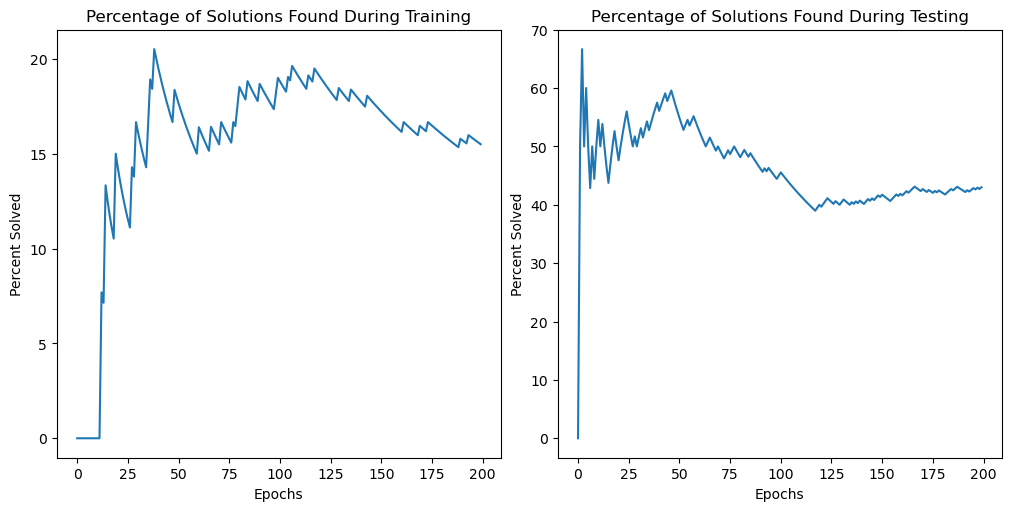

In [44]:
# Results summary
fig, axes = plt.subplots(1,2, figsize=(10,5), layout='constrained')

axes[0].plot(percent_solved_list)
axes[0].set_ylabel('Percent Solved')
axes[0].set_xlabel("Epochs")
axes[0].set_title('Percentage of Solutions Found During Training')

axes[1].plot(percent_solved_list_testing)
axes[1].set_ylabel('Percent Solved')
axes[1].set_xlabel("Epochs")
axes[1].set_title('Percentage of Solutions Found During Testing')

Text(0.5, 1.0, 'Cumulative Reward During Testing')

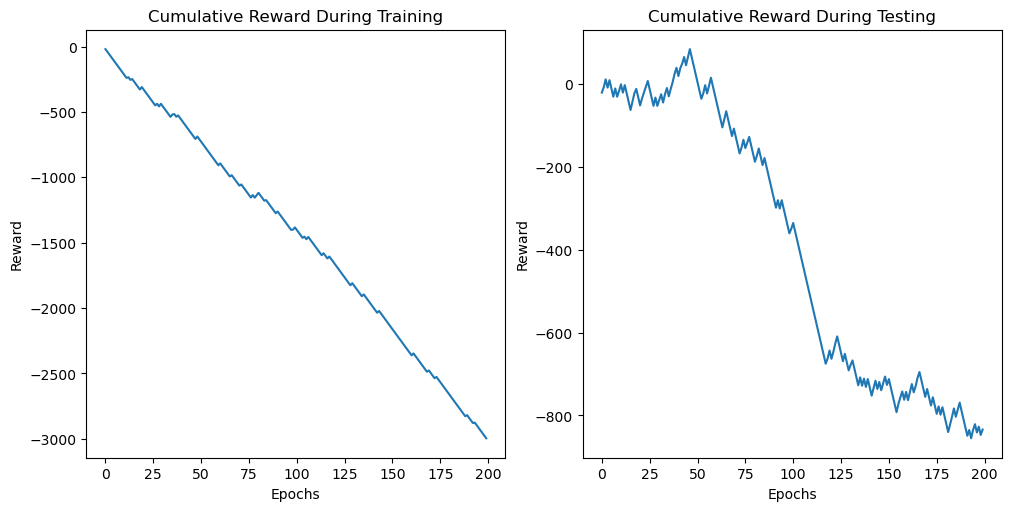

In [45]:
# Results summary
fig, axes = plt.subplots(1,2, figsize=(10,5), layout='constrained')

axes[0].plot(rewards_trained)
axes[0].set_ylabel('Reward')
axes[0].set_xlabel("Epochs")
axes[0].set_title('Cumulative Reward During Training') # 'Total Reward for Each Training Epoch'

axes[1].plot(rewards_tested)
axes[1].set_ylabel('Reward')
axes[1].set_xlabel("Epochs")
axes[1].set_title('Cumulative Reward During Testing') # 'Total Reward for Each Testing Epoch'